In [ ]:
# Importujeme si opět knihovny jako minule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

from keras import layers
from keras import ops
# %matplotlib ipympl

TensorFlow version: 2.16.2
Keras version: 3.6.0


# Transformery
- k tomuto tématu prakticky nebudu vytvářet žádné ukázky ze dvou důvodů
    - transformer modely mají komplikovanou architekturu a tudíž bych nestihl popsat všechny hlavnní části kódu
    - pro rozumné výsledky transformer modely obsahují obrovské množství parametrů (minumum v řádech desítek milionů)
- přikládám proto [odkaz](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/) přímo na ukázky kódu knihovny Keras kde je ukázka tvorby transformeru pro překlad z angličtiny do španělštiny

# Generativní modely
## VAE
- seznam state-of-art článků [zde](https://paperswithcode.com/method/vae)
- ukážeme si jak můžeme implementovat Variational Autoencoder
- pseudokód VAE by mohl vypadat následovně:

- implementujeme si tedy každou část pomocí vlastní třídy 

In [2]:
# https://keras.io/api/ops/ – Operations
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)
    
    def call(self, inputs):
        z_mean, z_var = inputs
        
        # Kolik objektů máme v batch
        batch = ops.shape(z_mean)[0]
        # Kolik dimenzí máme
        dimension = ops.shape(z_mean)[1]
        
        # Pro každý objekt v dávce (batch) náhodně vygenerujeme vektor (velikosti dimenze) z normálního rozdělení (se střední hodnotou 0 a rozptylem 1)
        # https://en.wikipedia.org/wiki/Normal_distribution
        epsilon = keras.random.normal(shape=(batch, dimension), seed=self.seed_generator)

        # Výpočet z (speciální vzorec pro VAE)
        return z_mean + ops.exp(0.5 * z_var) * epsilon

In [3]:
# Dimenze latentního prostoru
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Výstupní vrstvy
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_var])

# Definujeme vstup modelu a jeho výstupy
encoder = keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Vstupem bude z získaný z encoderu
latent_inputs = keras.Input(shape=(latent_dim,))

# Jdeme symetricky k encoderu
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Vytvoříme model VAE jako custom model v Kerasu jako subtřídu keras.Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # Použijeme vlastní metriky pro sledování ztrát 
        # https://keras.io/api/metrics/
        # Definujeme jako součet reconstruction loss + regularization loss
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        # reconstruction loss – rozdíl mezi originálními vstupními daty a rekonstruovaným (dekódovaným) výstupem
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

        # Kullback-Leibler divergence (KL divergence) – měří, jak moc se distribuce latentního prostoru liší od normálního rozdělení
        # regularization loss – nutí síť rozumné distribuci v latentním prostoru
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Definujeme metriky, které chceme sledovat
    # model sám bude uržovat hodnoty a sám si je bude resetovat
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape: # https://www.tensorflow.org/guide/autodiff
            # Kódování dat
            z_mean, z_var, z = self.encoder(data)

            # Dekódování dat
            reconstruction = self.decoder(z)

            # Výpočet ztrát
            # binary_crossentropy
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            # Kullback-Leibler divergence (KL divergence)
            kl_loss = -0.5 * (1 + z_var - ops.square(z_mean) - ops.exp(z_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

            # Celková ztráta
            total_loss = reconstruction_loss + kl_loss

        # Výpočet gradientů a aktualizace vah
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Aktualizujeme metriky definované jaok propery
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Vratíme hodnoty metrik pro jejich vypsání
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Spojíme train a test data
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# Přidáme dimenzionalitu
mnist_digits = np.expand_dims(mnist_digits, -1)

# Škálování
mnist_digits = mnist_digits / 255

mnist_digits.shape

(70000, 28, 28, 1)

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - kl_loss: 3.3687 - loss: 250.5563 - reconstruction_loss: 247.1876
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - kl_loss: 5.1159 - loss: 174.7488 - reconstruction_loss: 169.6329
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - kl_loss: 5.3915 - loss: 164.1553 - reconstruction_loss: 158.7638
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - kl_loss: 5.6499 - loss: 159.0957 - reconstruction_loss: 153.4457
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - kl_loss: 5.7912 - loss: 156.6742 - reconstruction_loss: 150.8830
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - kl_loss: 5.9282 - loss: 155.0249 - reconstruction_loss: 149.0967
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - kl_loss: 6.0141 - loss: 153.5790 - reconstruction_loss: 147.5649
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - kl_loss: 6.0514 - loss: 152.6530 - reconstruction_loss: 146.6016
Epoch 9/10
547/547 ━━━━━━━━━━━━━

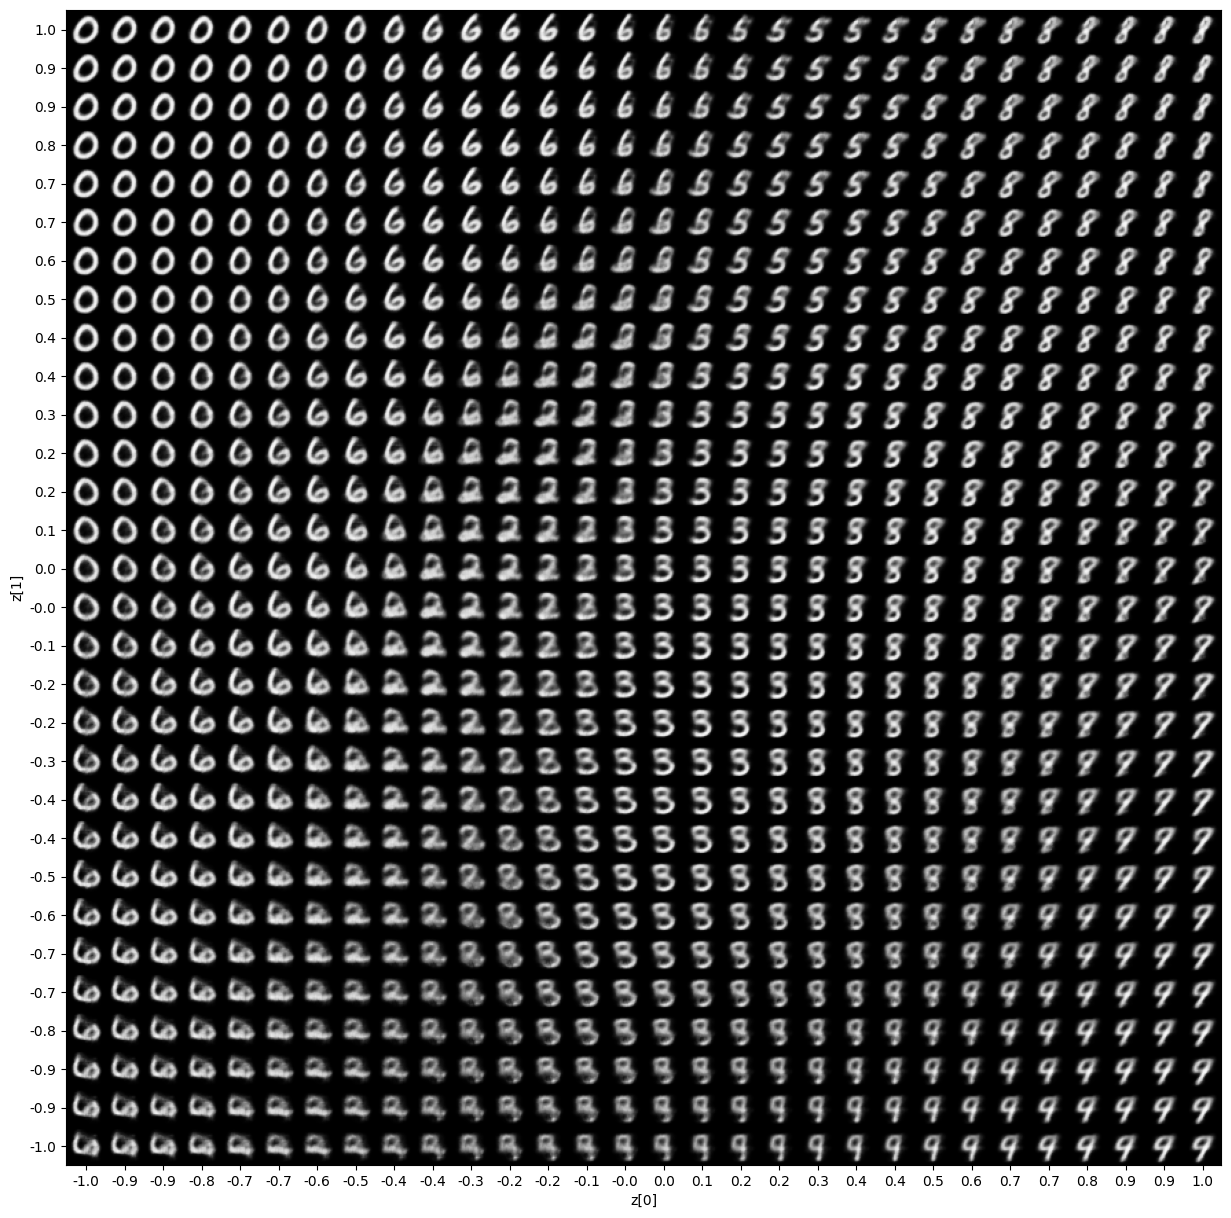

In [12]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

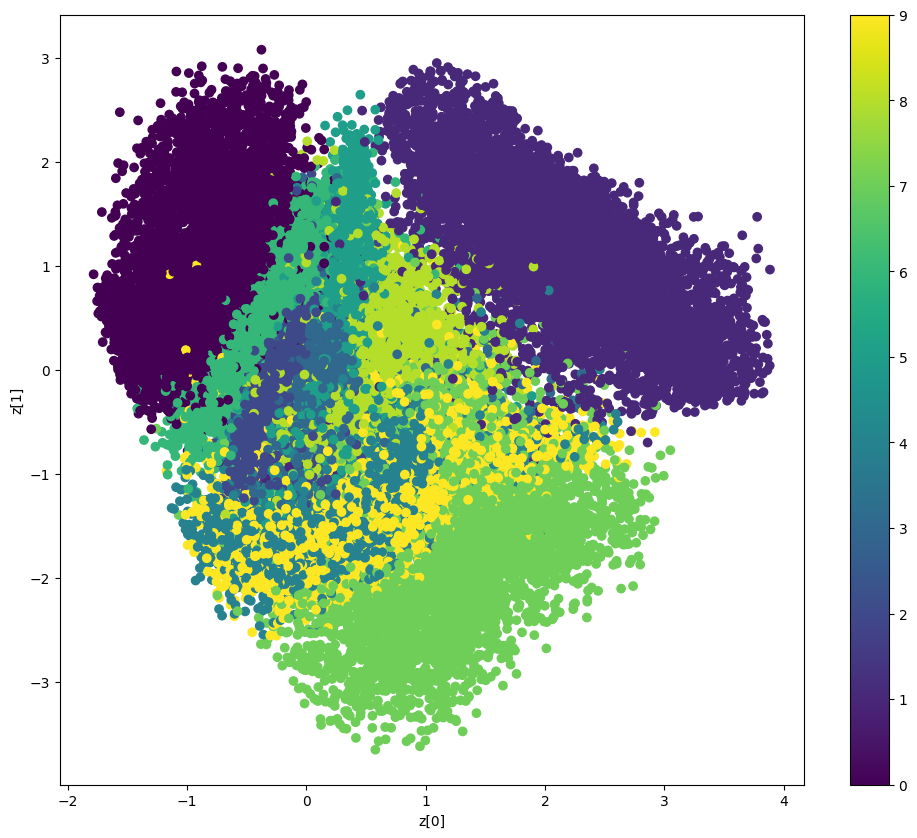

In [13]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# GAN
- ukázka implementace [zde](https://keras.io/examples/generative/conditional_gan/)
- popřípadě se podívejte na nějaký článek [zde](https://paperswithcode.com/method/gan)
- extrémě výkoný StyleGAN2 je rozšířením GAN